In [7]:
%load_ext autoreload
%autoreload 2

from pyro import sample, plate

from scipy.linalg import null_space, lstsq

from src.data.datasets import SiteDataset
import torch
import seaborn as sns
import pyro
from src.data.datasets import SiteDataset
from src.models.initial_model import InitialModel, TraceGuide
from pyro import distributions as dist

site_data = SiteDataset("5a0546857ecc773753327266")
floor = site_data.floors[0]
height, width = floor.info["map_info"]["height"], floor.info["map_info"]["width"]
floor_uniform = dist.Uniform(
    low=torch.tensor([0.0, 0.0]), high=torch.tensor([height, width])
).to_event(1)

trace = floor.traces[18]
matrices = trace.matrices
time = torch.tensor(matrices["time"])
wifi = torch.tensor(matrices["wifi"])
position = torch.tensor(matrices["position"])


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
tg = TraceGuide()
tg.to(dtype=torch.double);

In [9]:
model = InitialModel(trace)

from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam


# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 300

# Setup the optimizer
adam_params = {"lr": 0.01}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=3)
svi = SVI(model.model, model.guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step()

    print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 99679.1
[1] ELBO: 103825.3
[2] ELBO: 94911.1
[3] ELBO: 95955.1
[4] ELBO: 96815.7
[5] ELBO: 88139.5
[6] ELBO: 98322.9
[7] ELBO: 90844.3
[8] ELBO: 82035.6
[9] ELBO: 83616.1
[10] ELBO: 87556.1
[11] ELBO: 82884.4
[12] ELBO: 82971.9
[13] ELBO: 81845.0
[14] ELBO: 78531.6
[15] ELBO: 76505.7
[16] ELBO: 70412.2
[17] ELBO: 70892.0
[18] ELBO: 69519.1
[19] ELBO: 68484.0
[20] ELBO: 64779.2
[21] ELBO: 67552.6
[22] ELBO: 66617.5
[23] ELBO: 60833.3
[24] ELBO: 62873.2
[25] ELBO: 60030.5
[26] ELBO: 60435.7
[27] ELBO: 58104.7
[28] ELBO: 57371.5
[29] ELBO: 57181.8
[30] ELBO: 59813.4
[31] ELBO: 55419.9
[32] ELBO: 52905.2
[33] ELBO: 53159.0
[34] ELBO: 50636.5
[35] ELBO: 48243.7
[36] ELBO: 48510.9
[37] ELBO: 48566.0
[38] ELBO: 44751.1
[39] ELBO: 44016.6
[40] ELBO: 44054.2
[41] ELBO: 45128.8
[42] ELBO: 42210.8
[43] ELBO: 42102.8
[44] ELBO: 39515.0
[45] ELBO: 37229.2
[46] ELBO: 36952.0
[47] ELBO: 37955.3
[48] ELBO: 37416.9
[49] ELBO: 35415.9
[50] ELBO: 34407.2
[51] ELBO: 36309.9
[52] ELBO: 35306.9
[5

<AxesSubplot:>

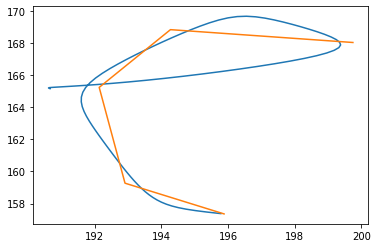

In [10]:
tt = torch.linspace(model.time[0], model.time[-1], 100)
loc, scale = model.trace_guide(tt.view(-1, 1))
loc = loc.detach()

sns.lineplot(x=loc[:, 0], y=loc[:, 1], sort=False)
sns.lineplot(x=model.position[:, 0], y=model.position[:, 1], sort=False)


In [13]:
model.trace_guide.log_scale.exp()

tensor(0.0710, grad_fn=<ExpBackward>)